# Discussion of a paper

We will study foot trajectories as descibed in <a href="https://ieeexplore.ieee.org/document/8961767" target="_blank">Foot Trajectory Planning Method with Adjustable Parameters for Complex Environment</a>

We will break down the foot trajectory into two phases, a swing phase and a stance phase. we will use 3rd-order <a href="https://en.wikipedia.org/wiki/Bézier_curve" target="_blank">Bezier curves</a> to describe the curves of each phase and to smoothen the impact of the transition between the two phases we will use a Sigmoid function.

A Bézier curve is a mapping from $s \in \left[0, 1\right]$ to convex combinations of points $P_0, P_1, \ldots, P_n$ in some vector space:
    
    
$$B(s) = \sum_{i=0}^{n} {n \choose i} s^{i} \left( 1 - s \right)^{n - i}P_i$$


with $n=3$:

$$B(s) = \sum_{i=0}^{3} {3 \choose i} s^{i} \left( 1 - s \right)^{3 - i}P_i $$

$$B(s) = \left( 1 - s \right)^3 P_0 + 3s\left( 1 - s \right)^2 P_1 + 3s^2\left( 1 - s \right) P_2 + s^3 P_3$$

To find the maximum we have to solve the differential equation

$$ \frac{dB}{ds} = 0 $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
import sympy as sp
s, P0, P1, P2, P3 = sp.symbols('s P_0 P_1 P_2 P_3')

In [3]:
B = (1-s)**3*P0+3*s*(1-s)**2*P1+3*s**2*(1-s)*P2+s**3*P3
B

P_0*(1 - s)**3 + 3*P_1*s*(1 - s)**2 + 3*P_2*s**2*(1 - s) + P_3*s**3

In [4]:
H, L = sp.symbols('H L')

In [5]:
B1 = B.subs(P0, sp.Matrix([[-L/2, 0]]).transpose())
B2 = B1.subs(P1, sp.Matrix([[0, H]]).transpose())
B3 = B2.subs(P2, sp.Matrix([[L/2, H]]).transpose())
B4 = B3.subs(P3, sp.Matrix([[L/2, 0]]).transpose())
B4

Matrix([
[L*s**3/2 + 3*L*s**2*(1 - s)/2 - L*(1 - s)**3/2],
[           3*H*s**2*(1 - s) + 3*H*s*(1 - s)**2]])

In [6]:
sp.solve(sp.diff(B4[1], s), s)

[1/2]

In [7]:
B4.subs(s, 1/2)

Matrix([
[0.1875*L],
[  0.75*H]])

## Swing Phase

The below figure shows the trajectory of the swing phase. We use from numpy the <a href="https://bezier.readthedocs.io/en/stable/python/reference/bezier.curve.html" target="_blank">bezier.curve module</a> to do the calculations. Red dots in the figure are the support points.

In [8]:
import bezier

step_length = 1.0
point_height = 1.0

points = np.asarray([
                     [-step_length/2, 0.0, step_length/2, step_length/2],
                     [0.0, point_height, point_height,0.0]
                    ])
curve = bezier.Curve(points, degree=3)

Text(0.5, 1.0, 'Swing phase')

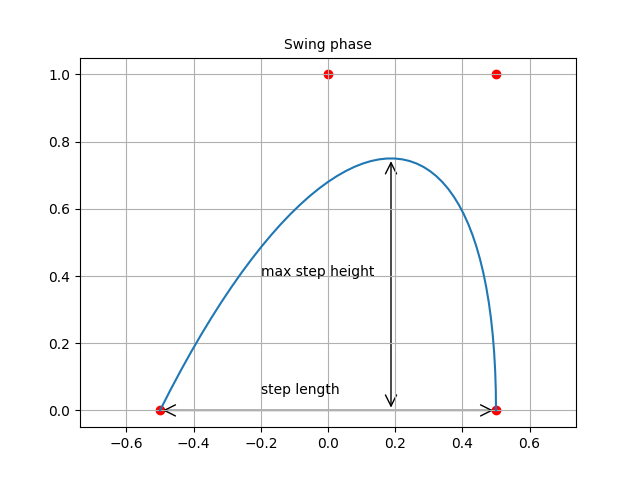

In [9]:
import matplotlib.patches as patches

fig, ax = plt.subplots()

plt.scatter(points[0], points[1], color='red')
curve.plot(50, ax=ax)
# plot step_length
l_points = np.zeros((2, 2))
l_points[0,0] = -step_length/2
l_points[1,0] = step_length/2
#plt.plot(l_points[0], l_points[1],'-k')
p1 = patches.FancyArrowPatch(l_points[0], l_points[1], arrowstyle='<->', mutation_scale=20)
ax.add_artist(p1)
plt.text(-0.2, 0.05, "step length")
# plot step_height
h_points = np.zeros((2, 2))
h_points[0,0] = 0.1875*step_length
h_points[1,0] = 0.1875*step_length
h_points[1,1] = 0.75*point_height
p2 = patches.FancyArrowPatch(h_points[0], h_points[1], arrowstyle='<->', mutation_scale=20)
ax.add_artist(p2)
plt.text(-0.2, 0.4, "max step height")


plt.axis('equal')  #<-- set the axes to the same scale

plt.grid(visible=True, which='major')
plt.title('Swing phase',fontsize=10)

## Support Phase

We will use a straight line for the stance phase

Text(0.5, 1.0, 'Support phase')

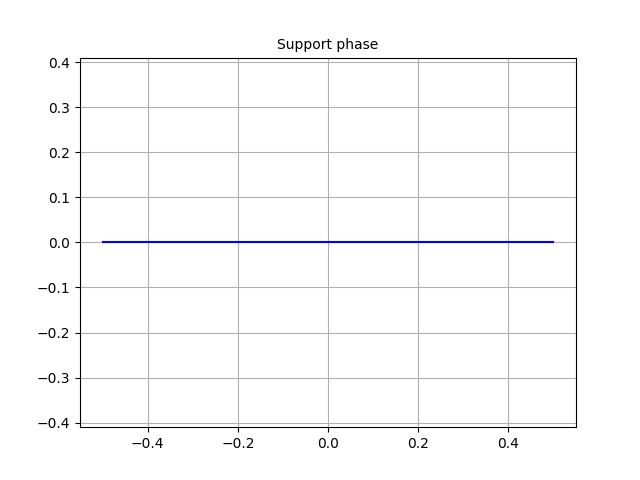

In [10]:
fig, ax = plt.subplots()

l_points = np.zeros((2, 2))
l_points[0,0] = -step_length/2
l_points[0,1] = step_length/2
plt.plot(l_points[0], l_points[1],'-b')

plt.axis('equal')  #<-- set the axes to the same scale

plt.grid(visible=True, which='major')
plt.title('Support phase',fontsize=10)

## Sigmoid function

The <a href="https://en.wikipedia.org/wiki/Sigmoid_function" target="_blank">sigmoid function</a> is defined as

$$ S\left( x \right) = \frac{1}{1+e^{-x}} $$ 

We introduce a truncation parameter $\epsilon \left( \epsilon\gt0 \right) $ and map the time $t \in \left[0, 1\right]$ to the input $s \in \left[0, 1\right]$ of our Bézier curve

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Text(0.5, 1.0, 'Sigmoid Function')

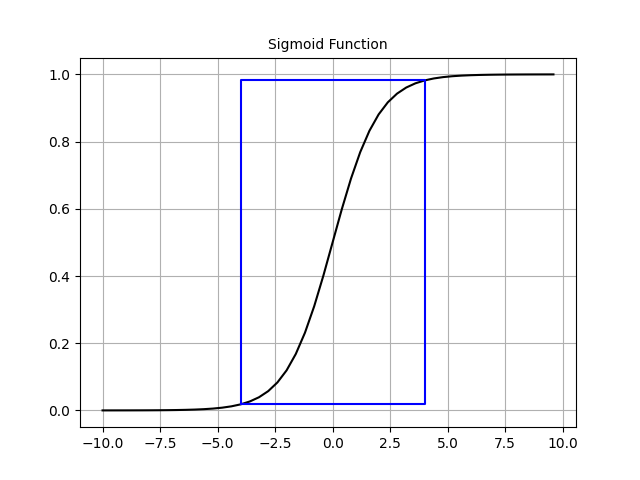

In [12]:
num_points = 50
epsilon = 4
points = np.zeros((2, num_points))

points[0] = np.linspace(-10, 10, num=num_points, endpoint=False)
points[1] = np.array(list(map(sigmoid, points[0])))

e_points = np.zeros((2, 5))
e_points[0,0] = -epsilon
e_points[1,0] = sigmoid(-epsilon)
e_points[0,1] = -epsilon
e_points[1,1] = sigmoid(epsilon)
e_points[0,2] = epsilon
e_points[1,2] = sigmoid(epsilon)
e_points[0,3] = epsilon
e_points[1,3] = sigmoid(-epsilon)
e_points[0,4] = e_points[0,0]
e_points[1,4] = e_points[1,0]

fig, ax = plt.subplots()
plt.plot(points[0], points[1],'-k')
plt.plot(e_points[0], e_points[1],'-b')

plt.grid(visible=True, which='major')
plt.title('Sigmoid Function',fontsize=10)

In [13]:
x, t, epsilon = sp.symbols('x t epsilon')

In [14]:
m = ((sp.exp(epsilon) + 1)/(sp.exp(epsilon) - 1))*(1/(sp.exp(-2*epsilon*(t-1/2))+1) - 1/(sp.exp(epsilon) + 1))
m

(-1/(exp(epsilon) + 1) + 1/(1 + exp(-2*epsilon*(t - 0.5))))*(exp(epsilon) + 1)/(exp(epsilon) - 1)

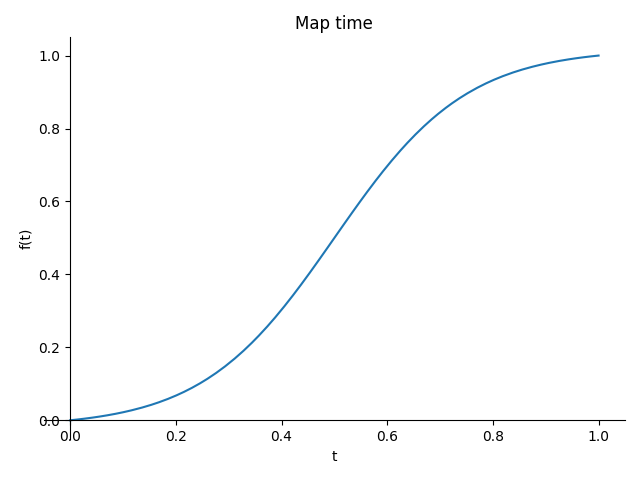

In [15]:
from sympy.plotting import plot

plot(m.subs(epsilon, 4), (t, 0, 1), title='Map time')

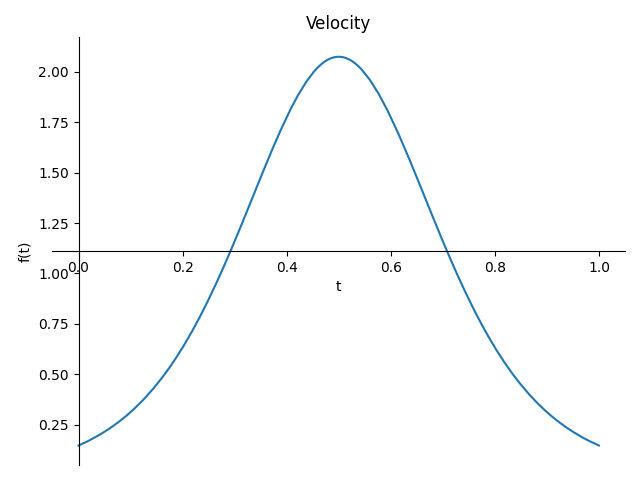

In [16]:
plot(sp.diff(m.subs(epsilon, 4), t), (t, 0, 1), title='Velocity')

## Putting everything together

We start with the stance phase and select a number of points from the interval $\left[0, 1\right]$ using our sigmoid function. Then we select the same number of points for the swing phase but we do not include the endpoints since they are already included in the stance phase

In [17]:
def adapt_velocity(eps, times):
    return [((np.exp(eps) + 1)/(np.exp(eps) - 1))*(1/(np.exp(-2*eps*(t-1/2))+1) - 1/(np.exp(eps) + 1)) for t in times]

In [18]:
def stance_phase(l, eps, times):
    return l * np.array(adapt_velocity(eps, np.linspace(0, 1, num=N))) - l/2

In [19]:
def swing_phase(l, h, eps, times):
    points = np.asarray([
                          [-l/2, 0.0, l/2, l/2],
                          [0.0, h/0.75, h/0.75,0.0]
                          ])
    curve = bezier.Curve(points, degree=3)
    return curve.evaluate_multi(times)

Text(0.5, 1.0, 'Foot Trajectory')

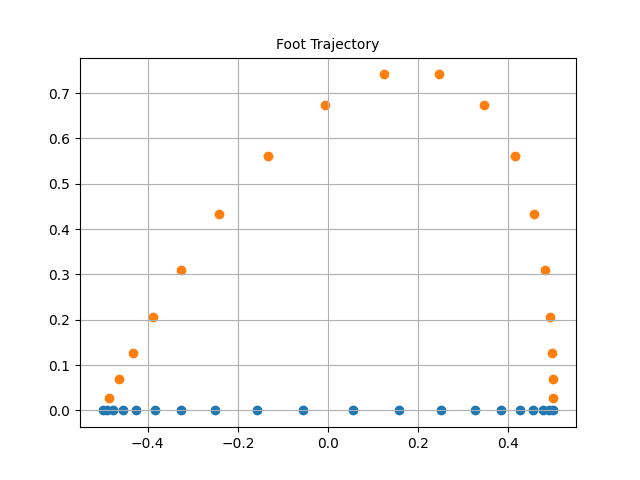

In [20]:
N = 20 # number of points
step_length = 1.0
step_height = 0.75
eps = 4

v_adj = np.array(adapt_velocity(4, np.linspace(0, 1, num=N)))

l_points = np.zeros((2, N))
l_points[0] = step_length * v_adj - step_length/2

# remove first and lest element from v_adj because it is already covered by the stance phase
s_points = np.array(swing_phase(step_length, step_height, eps, v_adj[1:-1]))

fig, ax = plt.subplots()
plt.scatter(l_points[0], l_points[1])
plt.scatter(s_points[0], s_points[1])

plt.grid(visible=True, which='major')
plt.title('Foot Trajectory',fontsize=10)